In [16]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Bai tap AI Samsung co ban/countries.csv')
data

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
240,YE,15.552727,48.516388,Yemen
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia


In [17]:
data.describe()

,latitude,longitude
count,244.000000,244.000000
mean,16.253109,13.294814
std,27.031206,73.976477
min,-75.250973,-177.156097
25%,-0.301710,-38.092008
50%,16.869235,18.182149
75%,38.965238,49.046734
max,77.553604,179.414413


In [18]:
data = data.dropna(subset=['latitude', 'longitude'])

**1. Dựa vào dữ liệu sau, hiển thị tọa độ của theo lat và lon của các nước lên một bản đồ**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns
from sklearn.cluster import KMeans
import folium
from folium import plugins

world_map = folium.Map(
    location = [22,0],
    zoom_start = 2,
    tiles = 'CartoDB Voyager',
    prefer_canvas = True,
)

marker_cluster = plugins.MarkerCluster().add_to(world_map)

for i, row in data.iterrows():
  folium.Marker(
      location = [row['latitude'], row['longitude']],
      popup = f"<strong>{row['country']}</strong>",
      icon = folium.Icon(color = 'cadetblue',icon = 'info-sign')
).add_to(marker_cluster)

folium.LayerControl().add_to(world_map)
heat_data = [[row['latitude'],row['longitude']] for index, row in data.iterrows()]
plugins.HeatMap(heat_data,radius = 15, max_zoom = 1).add_to(world_map)
plugins.Fullscreen(position = 'topleft').add_to(world_map)
world_map










In [20]:
X = data[['latitude','longitude']].values


**2. Phân cụm theo 3 thuật toán K-Means, DBSCAN, và DPC**

**1. K-Means**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


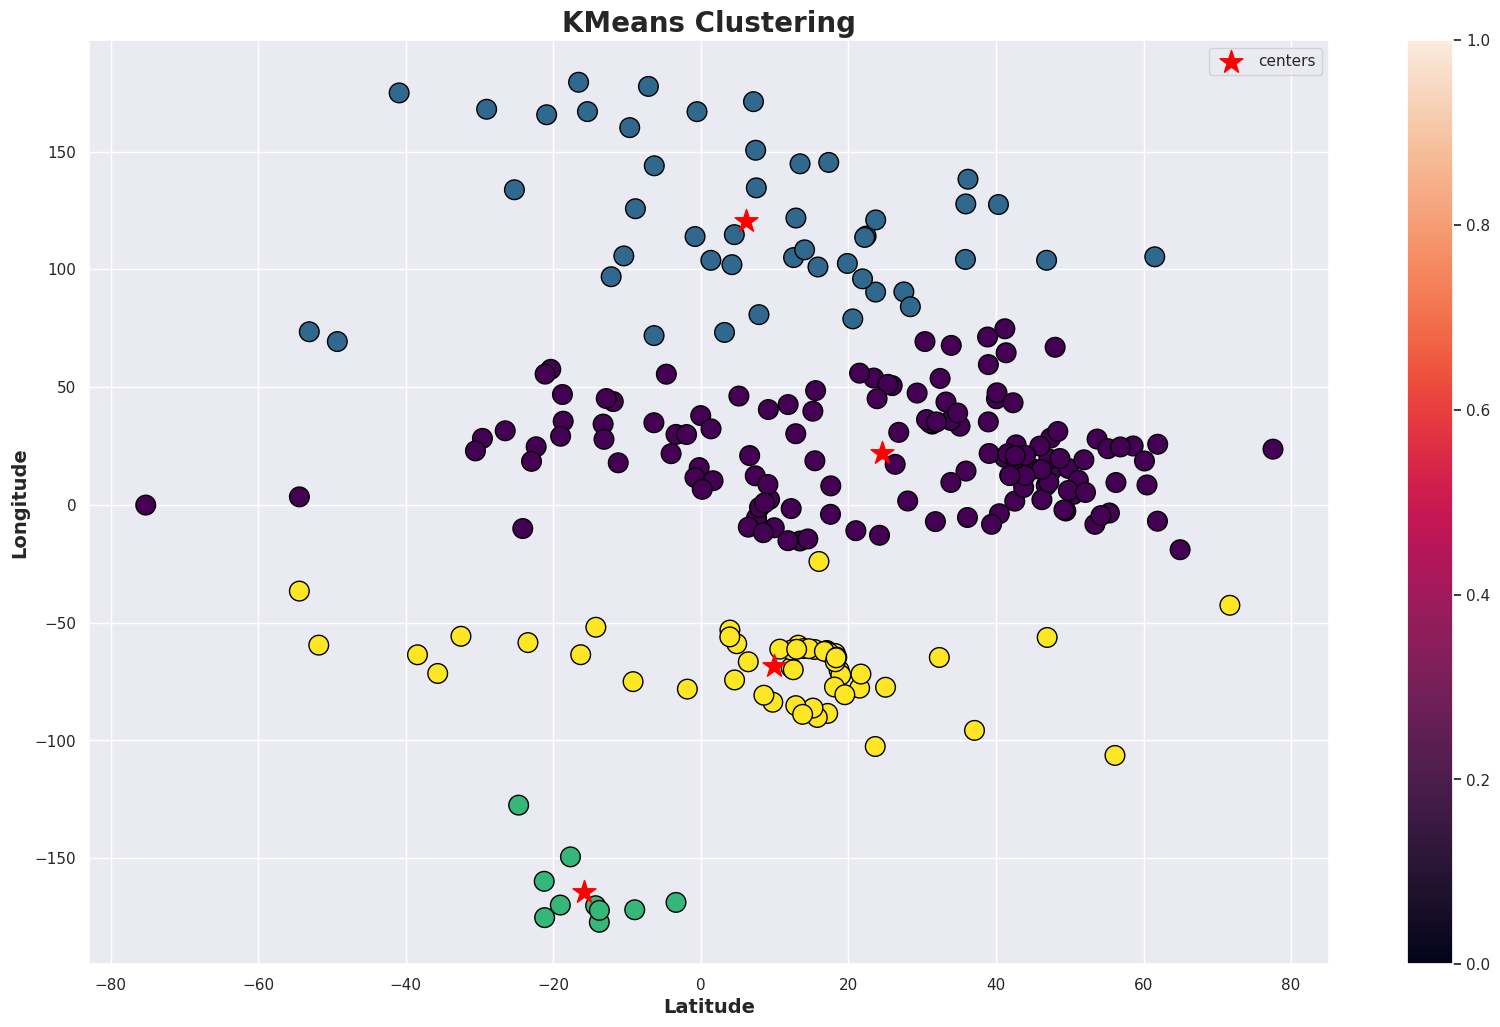

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sns.set(style = "darkgrid")
plt.figure(figsize = (20,12))
kmeans = KMeans(n_clusters = 4,random_state = 0)
y_kmeans = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
plt.scatter(X[:, 0],X[:, 1], c = y_kmeans, marker = 'o', edgecolor = 'black',cmap = 'viridis', s = 200)


plt.xlabel("Latitude",fontsize = 14,fontweight = 'bold')
plt.ylabel("Longitude",fontsize = 14,fontweight = 'bold')
plt.title("KMeans Clustering",fontsize = 20,fontweight = 'bold')
plt.scatter(centers[:, 0],centers[:, 1],c = 'red',s = 300,marker = '*',label = 'centers')
plt.legend(loc = 'best')
plt.colorbar()

plt.show()


**2. DBSCAN**

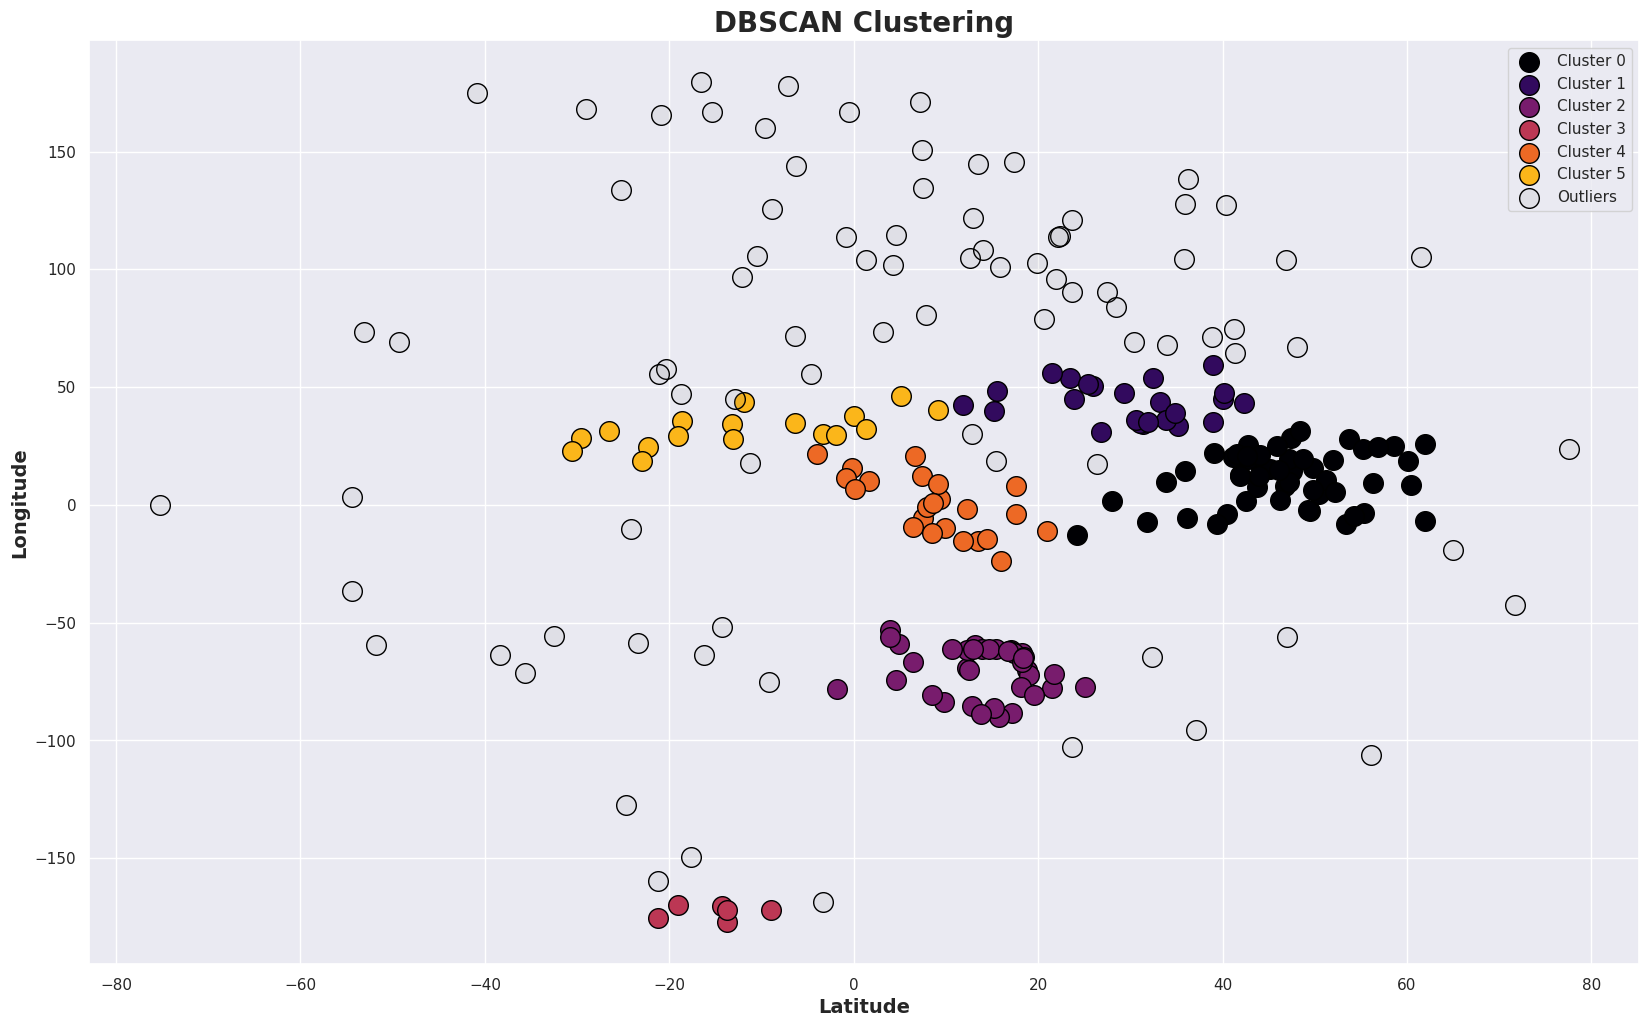

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

sns.set(style = "darkgrid")
dbscan = DBSCAN(eps = 10, min_samples = 6)
y_dbscan = dbscan.fit_predict(X)

unique_labels = set(y_dbscan)
colors = [plt.cm.inferno(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize = (20,12))

for k,col in zip(unique_labels, colors):
  if k == -1:
    col = [0.5, 0.5, 0.5, 0.1]
  class_member_mask = (y_dbscan == k)
  tmp = X[class_member_mask]
  plt.scatter(tmp[:, 0], tmp[:, 1], s = 200, c = [col], edgecolors = 'black', label = f'Cluster {k}' if k != -1 else 'Outliers')

plt.title('DBSCAN Clustering',fontsize = 20,fontweight = 'bold')
plt.xlabel('Latitude',fontsize = 14,fontweight = 'bold')
plt.ylabel('Longitude',fontsize = 14,fontweight = 'bold')
plt.legend(loc = 'best')

plt.show()




**3. Density Peak Clustering**

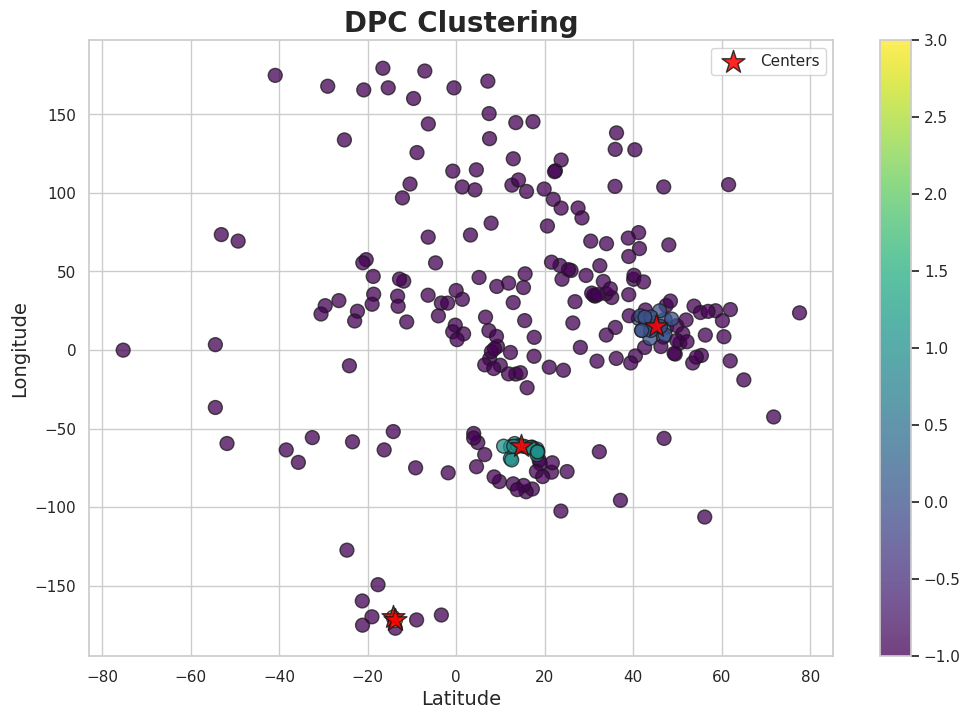

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import seaborn as sns


sns.set(style="whitegrid")


X_scaled = StandardScaler().fit_transform(X)


distances = pairwise_distances(X_scaled)


dc = np.percentile(distances, 2)
rho = np.sum(distances < dc, axis=1)


delta = np.zeros_like(rho)
for i in range(len(rho)):
    higher_density = np.where(rho > rho[i])[0]
    if len(higher_density) > 0:
        delta[i] = np.min(distances[i, higher_density])
    else:
        delta[i] = np.max(distances[i, :])

rho_delta = rho * delta
centers = np.argsort(-rho_delta)[:4]

labels = -np.ones(len(X))
for i, center in enumerate(centers):
    labels[center] = i
    mask = (distances[center, :] < dc) & (rho < rho[center])
    labels[mask] = i

plt.figure(figsize=(12, 8))

scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis', edgecolor='k', alpha=0.75)

plt.scatter(X[centers, 0], X[centers, 1], c='red', s=300, alpha=0.85, marker='*', edgecolor='k', label='Centers')


plt.title("DPC Clustering", fontsize=20, fontweight='bold')
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)


plt.legend(loc='best')


plt.colorbar(scatter)

plt.show()


**3. So sánh và nhận xét kết quả phân cụm**

# <span style="color:#2E8B57">**So sánh Kết quả Phân cụm**</span>

## <span style="color:#FF8C00">**K-Means Clustering**</span>
* <span style="color:#4682B4">**Mô tả:**</span> K-Means chia dữ liệu thành 4 cụm, với các trung tâm cụm được biểu diễn bằng các ngôi sao màu đỏ.
* <span style="color:#32CD32">**Ưu điểm:**</span>
  * K-Means hoạt động tốt khi các cụm có dạng hình cầu và kích thước tương đương.
  * Biểu đồ cho thấy các cụm tương đối rõ ràng với trung tâm cụm được xác định chính xác.
* <span style="color:#DC143C">**Nhược điểm:**</span>
  * K-Means gặp khó khăn trong việc xử lý các cụm có hình dạng hoặc kích thước khác nhau.
  * Các điểm dữ liệu có thể bị ép vào một cụm nào đó ngay cả khi chúng không thuộc cụm nào rõ ràng.

## <span style="color:#FF8C00">**DBSCAN Clustering**</span>
* <span style="color:#4682B4">**Mô tả:**</span> DBSCAN phát hiện được 6 cụm rõ ràng cùng với một số điểm ngoại lai (outliers) được biểu diễn bằng màu trắng.
* <span style="color:#32CD32">**Ưu điểm:**</span>
  * DBSCAN tốt trong việc xử lý các cụm có hình dạng và mật độ khác nhau.
  * Có khả năng phát hiện các điểm ngoại lai. Biểu đồ cho thấy các cụm rõ ràng hơn và các điểm ngoại lai được tách biệt.
* <span style="color:#DC143C">**Nhược điểm:**</span>
  * DBSCAN có thể gặp khó khăn khi các cụm có mật độ khác nhau hoặc khi cần phải điều chỉnh cẩn thận các tham số `eps` và `min_samples`.
  * Biểu đồ cho thấy một số điểm có thể không được gán vào cụm nào (outliers).

## <span style="color:#FF8C00">**DPC (Density Peaks Clustering)**</span>
* <span style="color:#4682B4">**Mô tả:**</span> DPC phân cụm dựa trên mật độ điểm dữ liệu, với các trung tâm cụm được xác định dựa trên mật độ cao nhất.
* <span style="color:#32CD32">**Ưu điểm:**</span>
  * DPC tốt trong việc phát hiện các cụm có mật độ cao và không yêu cầu biết trước số lượng cụm.
  * Biểu đồ cho thấy các trung tâm cụm được xác định rõ ràng và các cụm dựa trên mật độ xung quanh các trung tâm này.
* <span style="color:#DC143C">**Nhược điểm:**</span>
  * DPC có thể khó điều chỉnh và không phải lúc nào cũng hoạt động tốt với các dữ liệu có mật độ rất không đồng đều.
  * Biểu đồ cho thấy một số cụm có thể không rõ ràng và dễ bị ảnh hưởng bởi mật độ điểm dữ liệu.

## <span style="color:#2E8B57">**Nhận xét chung**</span>
* <span style="color:#4B0082">**K-Means:**</span> Phù hợp khi dữ liệu có các cụm hình cầu với kích thước tương đối đều. Tuy nhiên, nó có thể không tốt khi các cụm có hình dạng và kích thước khác nhau.
* <span style="color:#4B0082">**DBSCAN:**</span> Tốt khi làm việc với dữ liệu có cụm không đều và khi cần phát hiện các điểm ngoại lai. Nhưng cần điều chỉnh tham số cẩn thận.
* <span style="color:#4B0082">**DPC:**</span> Tốt khi cần phát hiện các cụm có mật độ cao mà không cần biết trước số lượng cụm. Tuy nhiên, khó điều chỉnh và có thể bị ảnh hưởng bởi mật độ dữ liệu không đồng đều.
